# convert height values

In [1]:
# import modules

# basics
import os, glob
import warnings
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import geopandas as gp
import rasterio
from scipy.interpolate import LinearNDInterpolator

## load data

### DEM and slope with geoid for conversion

In [2]:
# DEM and geoid model
# 1 m DEM and derivatives
src_1m = rasterio.open('../data/DEMs/DEMs_Cali/DEMs_SAF/SGM_AOI_4326_1m_subset3R.tif')
src_1m_slp = rasterio.open('../data/DEMs/DEMs_Cali/DEMs_SAF/SGM_AOI_4326_1m_slope.tif')

# Geoid undulation raster
src_geoid = rasterio.open('../data/DEMs/DEMs_Cali/DEMs_SAF/us_noaa_g2018u0_4326_2.tif')

### ICESat

In [3]:
ATL03_output_path = '../data/tracks/ATL03/California/SAF/ATL03_20220901033738_10881602_005_01_SGM/'

# load in extracted hdf files of all ground tracks
ATL03_land_files = glob.glob(os.path.join(ATL03_output_path, 'ATL03_Signal_*.hdf'))
ATL03_land_files.sort()

# set up a dataframe list and fill with dataframes of each individual ground track (6 total)
ATL03_list = []
for i in range(len(ATL03_land_files)):
    ATL03_df = pd.read_hdf(ATL03_land_files[i], mode='r')
    ATL03_df = ATL03_df.sort_values(by=['alongtrack'], ascending=True).reset_index()
    ATL03_list.append(ATL03_df)

# define names of beams   
tracknames = ['GT1L', 'GT1R', 'GT2L', 'GT2R', 'GT3L', 'GT3R']

In [35]:
# see which beam has the highest point density
for i in range(len(ATL03_list)):
    print(f'Mean point density of {tracknames[i]}: {len(ATL03_list[i])/ATL03_list[i].alongtrack_base.iloc[-1]:.1f} photons per m')

Mean point density of GT1L: 0.7 photons per m
Mean point density of GT1R: 2.7 photons per m
Mean point density of GT2L: 0.6 photons per m
Mean point density of GT2R: 2.1 photons per m
Mean point density of GT3L: 0.7 photons per m
Mean point density of GT3R: 3.0 photons per m


In [4]:
# pick one beam to work with (beam 6 --> GT3R)
ATL03_df = ATL03_list[5]

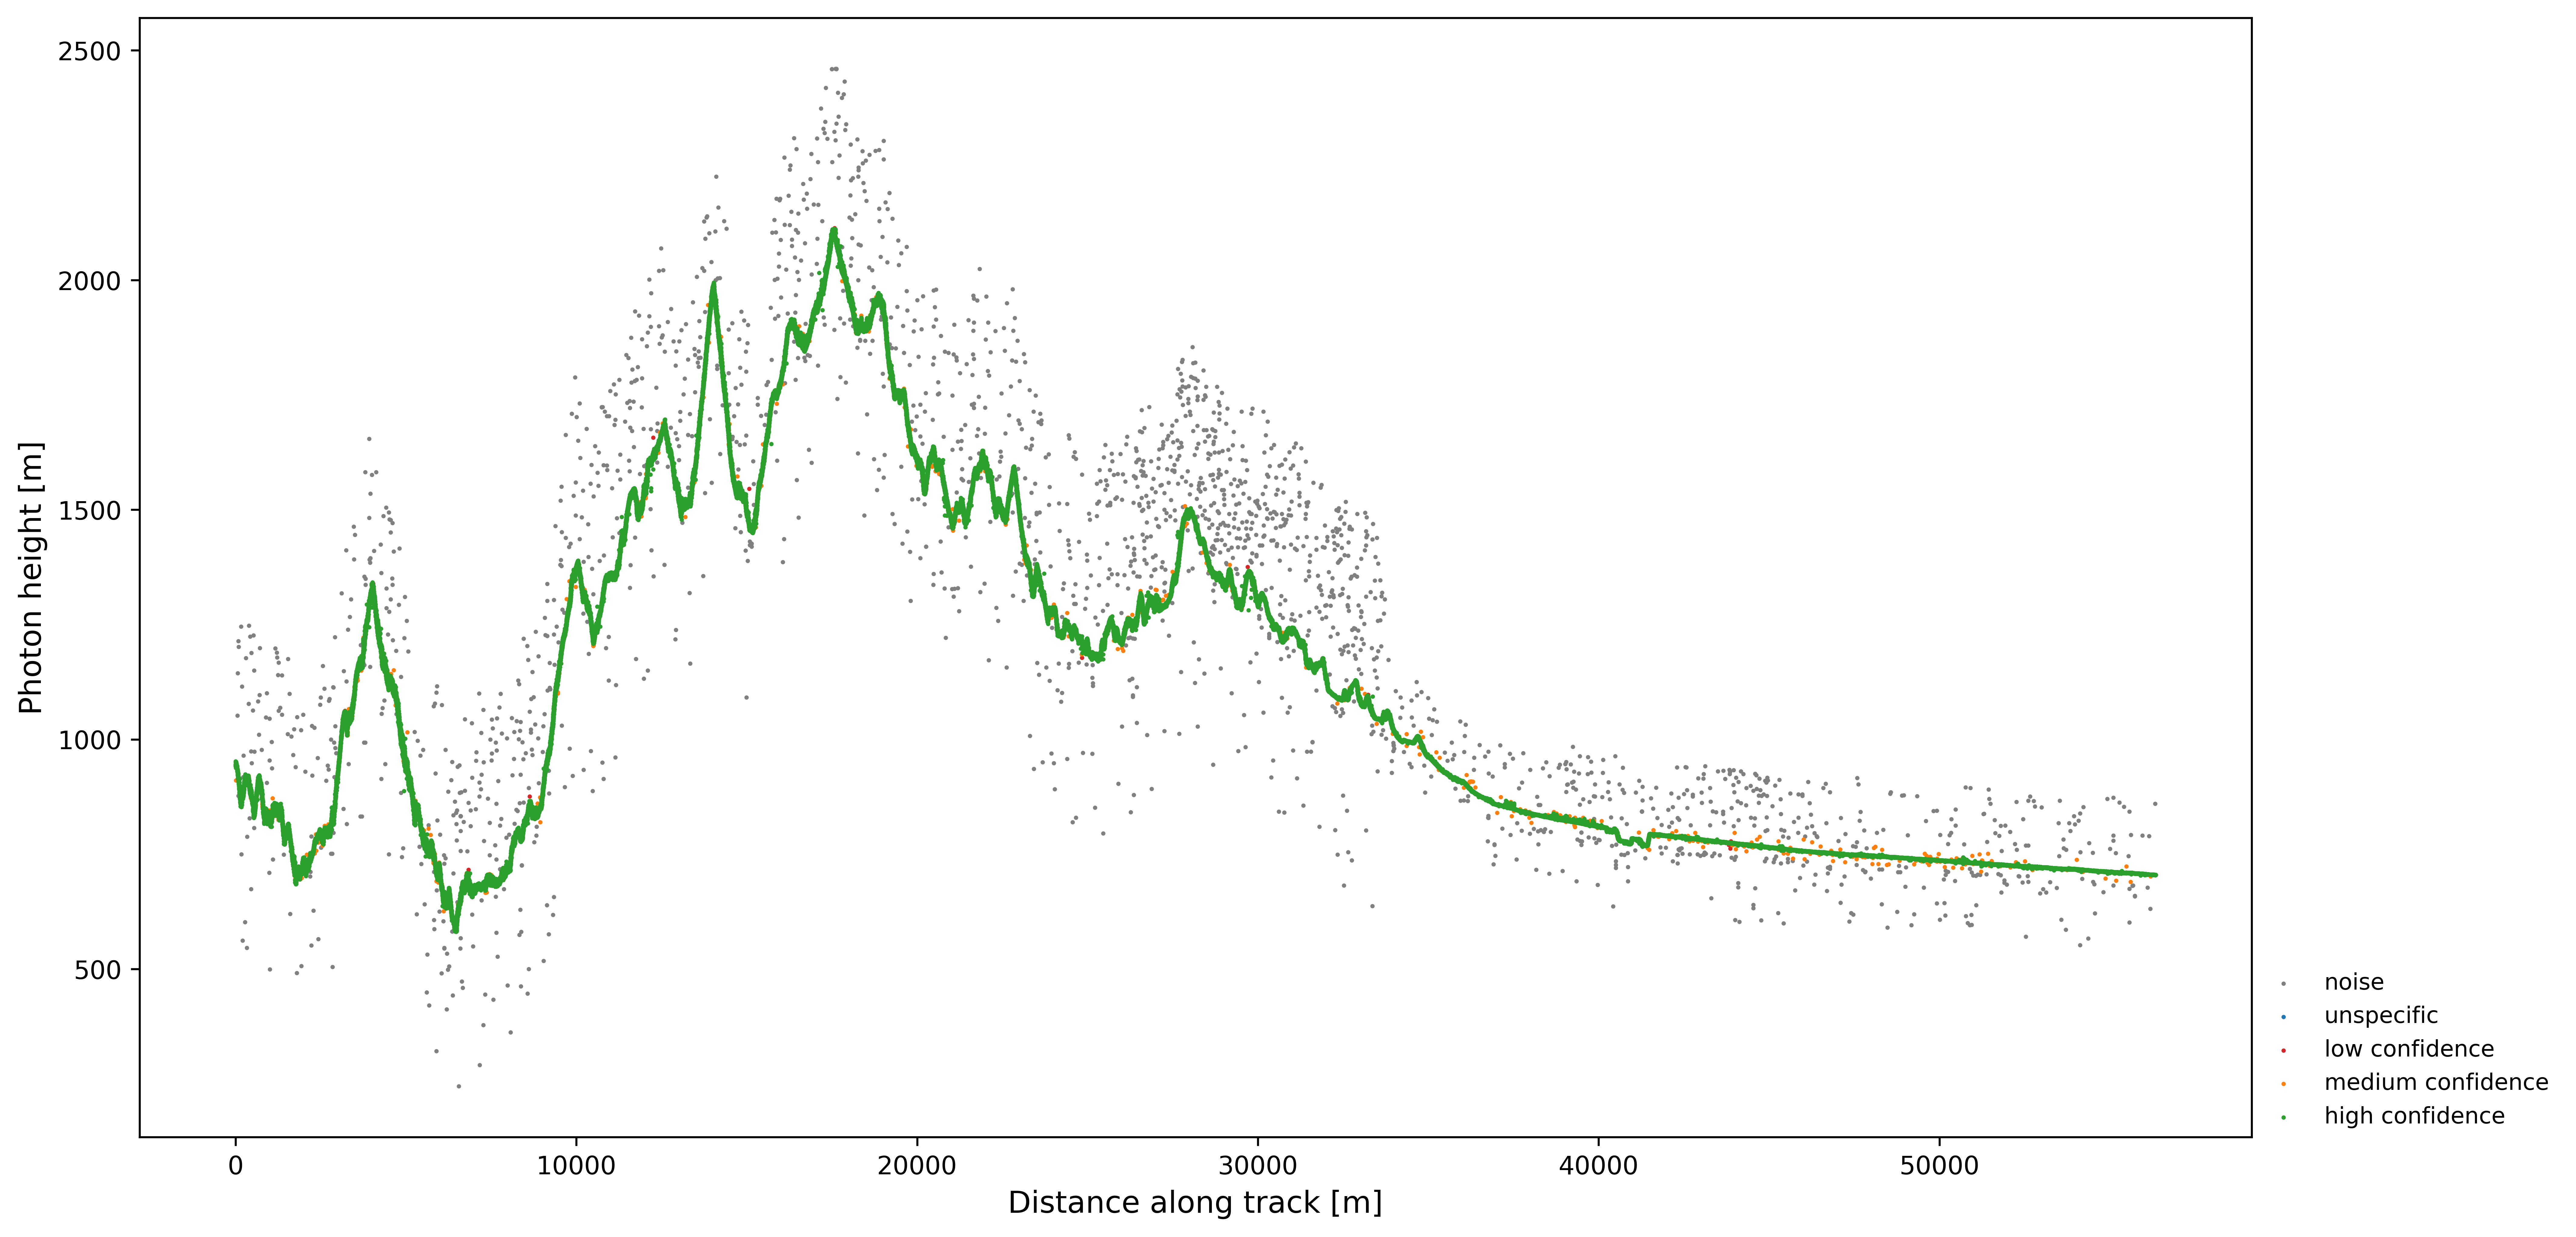

In [34]:
# plot
fig, ax = plt.subplots(1,1, figsize=(15,8))
fig.set_dpi(600)
ax.scatter(ATL03_df['alongtrack_base'][ATL03_df['Land'] == 0],  ATL03_df['Photon_Height'][ATL03_df['Land'] == 0],  s=0.5, label='noise', c='gray')
ax.scatter(ATL03_df['alongtrack_base'][ATL03_df['Land'] == -1], ATL03_df['Photon_Height'][ATL03_df['Land'] == -1], s=0.5, label='unspecific', c='tab:blue')
ax.scatter(ATL03_df['alongtrack_base'][ATL03_df['Land'] == 2],  ATL03_df['Photon_Height'][ATL03_df['Land'] == 2],  s=0.5, label='low confidence', c='tab:red')
ax.scatter(ATL03_df['alongtrack_base'][ATL03_df['Land'] == 3],  ATL03_df['Photon_Height'][ATL03_df['Land'] == 3],  s=0.5, label='medium confidence', c='tab:orange')
ax.scatter(ATL03_df['alongtrack_base'][ATL03_df['Land'] == 4],  ATL03_df['Photon_Height'][ATL03_df['Land'] == 4],  s=0.5, label='high confidence', c='tab:green')
ax.set_ylabel('Photon height [m]', fontsize=12)
ax.set_xlabel('Distance along track [m]', fontsize=12)
ax.legend(loc=(1.0, 0), frameon=False, fontsize=9);

In [38]:
# total length in m
ATL03_df.alongtrack_base.iloc[-1]

56343.75410158455

In [5]:
# remove all photons that are below medium confidence (noise, unspecified, low confidence)
ATL03_df = ATL03_df[ATL03_df.Land > 2]

print(f'Mean point density: {len(ATL03_df)/ATL03_df.alongtrack_base.iloc[-1]:.2f} points per m')

Mean point density: 2.89 points per m


## merge ICESat and DEMs

In [6]:
# gdf = None 
# turn pandas dataframe into geopandas geodataframe
gdf = gp.GeoDataFrame(ATL03_df, geometry=gp.points_from_xy(ATL03_df.Longitude, ATL03_df.Latitude), crs=4326)
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

# add new columns for data values
# geoid (to convert orthometric <-> ellipsoidal heights)
gdf['geoid'] = [x for x in src_geoid.sample(coord_list)]
gdf['geoid_float'] = gdf.geoid.astype(float)

# 1m DEM
gdf['dem_1m'] = [x for x in src_1m.sample(coord_list)]
gdf['dem_1m_navd88'] = gdf.dem_1m.astype(float)
gdf['dem_1m_navd88'] = gdf['dem_1m_navd88'].replace({src_1m.nodata: np.nan})

# slope
gdf['dem_1m_slp'] = [x for x in src_1m_slp.sample(coord_list)]
gdf['dem_1m_slp_float'] = gdf.dem_1m_slp.astype(float)
gdf['dem_1m_slp_float'] = gdf['dem_1m_slp_float'].replace({src_1m_slp.nodata: np.nan})

## subset dataframe

In [7]:
# print columns
gdf.columns

Index(['index', 'Latitude', 'Longitude', 'Photon_Height', 'Land', 'Easting',
       'Northing', 'crosstrack', 'alongtrack', 'alongtrack_base', 'geometry',
       'geoid', 'geoid_float', 'dem_1m', 'dem_1m_navd88', 'dem_1m_slp',
       'dem_1m_slp_float'],
      dtype='object')

In [7]:
# drop redundant columns
gdf_short = gdf.drop(['Land', 'Northing', 'Easting', 'crosstrack', 'alongtrack', 'geoid', 'dem_1m', 'dem_1m_slp'], axis=1)

# because the beam is longer than the DEM, make a new gdf that is clipped to the DEM extent
# there are also some artefacts in the DEM border, these are removed as well
ind_dem1, = np.where(gdf.dem_1m_navd88 > 0)
gdf_short = gdf_short.iloc[ind_dem1].iloc[5:-5].reset_index()
gdf_short

,level_0,index,Latitude,Longitude,Photon_Height,alongtrack_base,geometry,geoid_float,dem_1m_navd88,dem_1m_slp_float
0,65189,1465798,34.382644,-117.965616,1593.746338,22027.387204,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913
1,65190,1465797,34.382644,-117.965616,1595.324829,22027.390305,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913
2,65191,1465799,34.382644,-117.965616,1596.407104,22027.392431,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913
3,65192,1465795,34.382644,-117.965616,1602.720825,22027.404605,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913
4,65193,1465800,34.382650,-117.965617,1595.209717,22028.102334,POINT (-117.96562 34.38265),-31.456400,1627.451904,42.367153
...,...,...,...,...,...,...,...,...,...,...
74744,144066,1544671,34.609097,-117.991834,749.839539,47252.538308,POINT (-117.99183 34.60910),-32.193001,782.882568,0.782531
74745,144067,1544675,34.609104,-117.991834,749.403809,47253.254661,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551
74746,144068,1544676,34.609104,-117.991834,749.800659,47253.255437,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551
74747,144069,1544674,34.609104,-117.991834,749.871033,47253.255575,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551


In [8]:
# reset the alongtrack values
gdf_short['alongtrack_new'] = (gdf_short.alongtrack_base - np.ones(len(gdf_short))*gdf_short.alongtrack_base.iloc[0]).tolist()

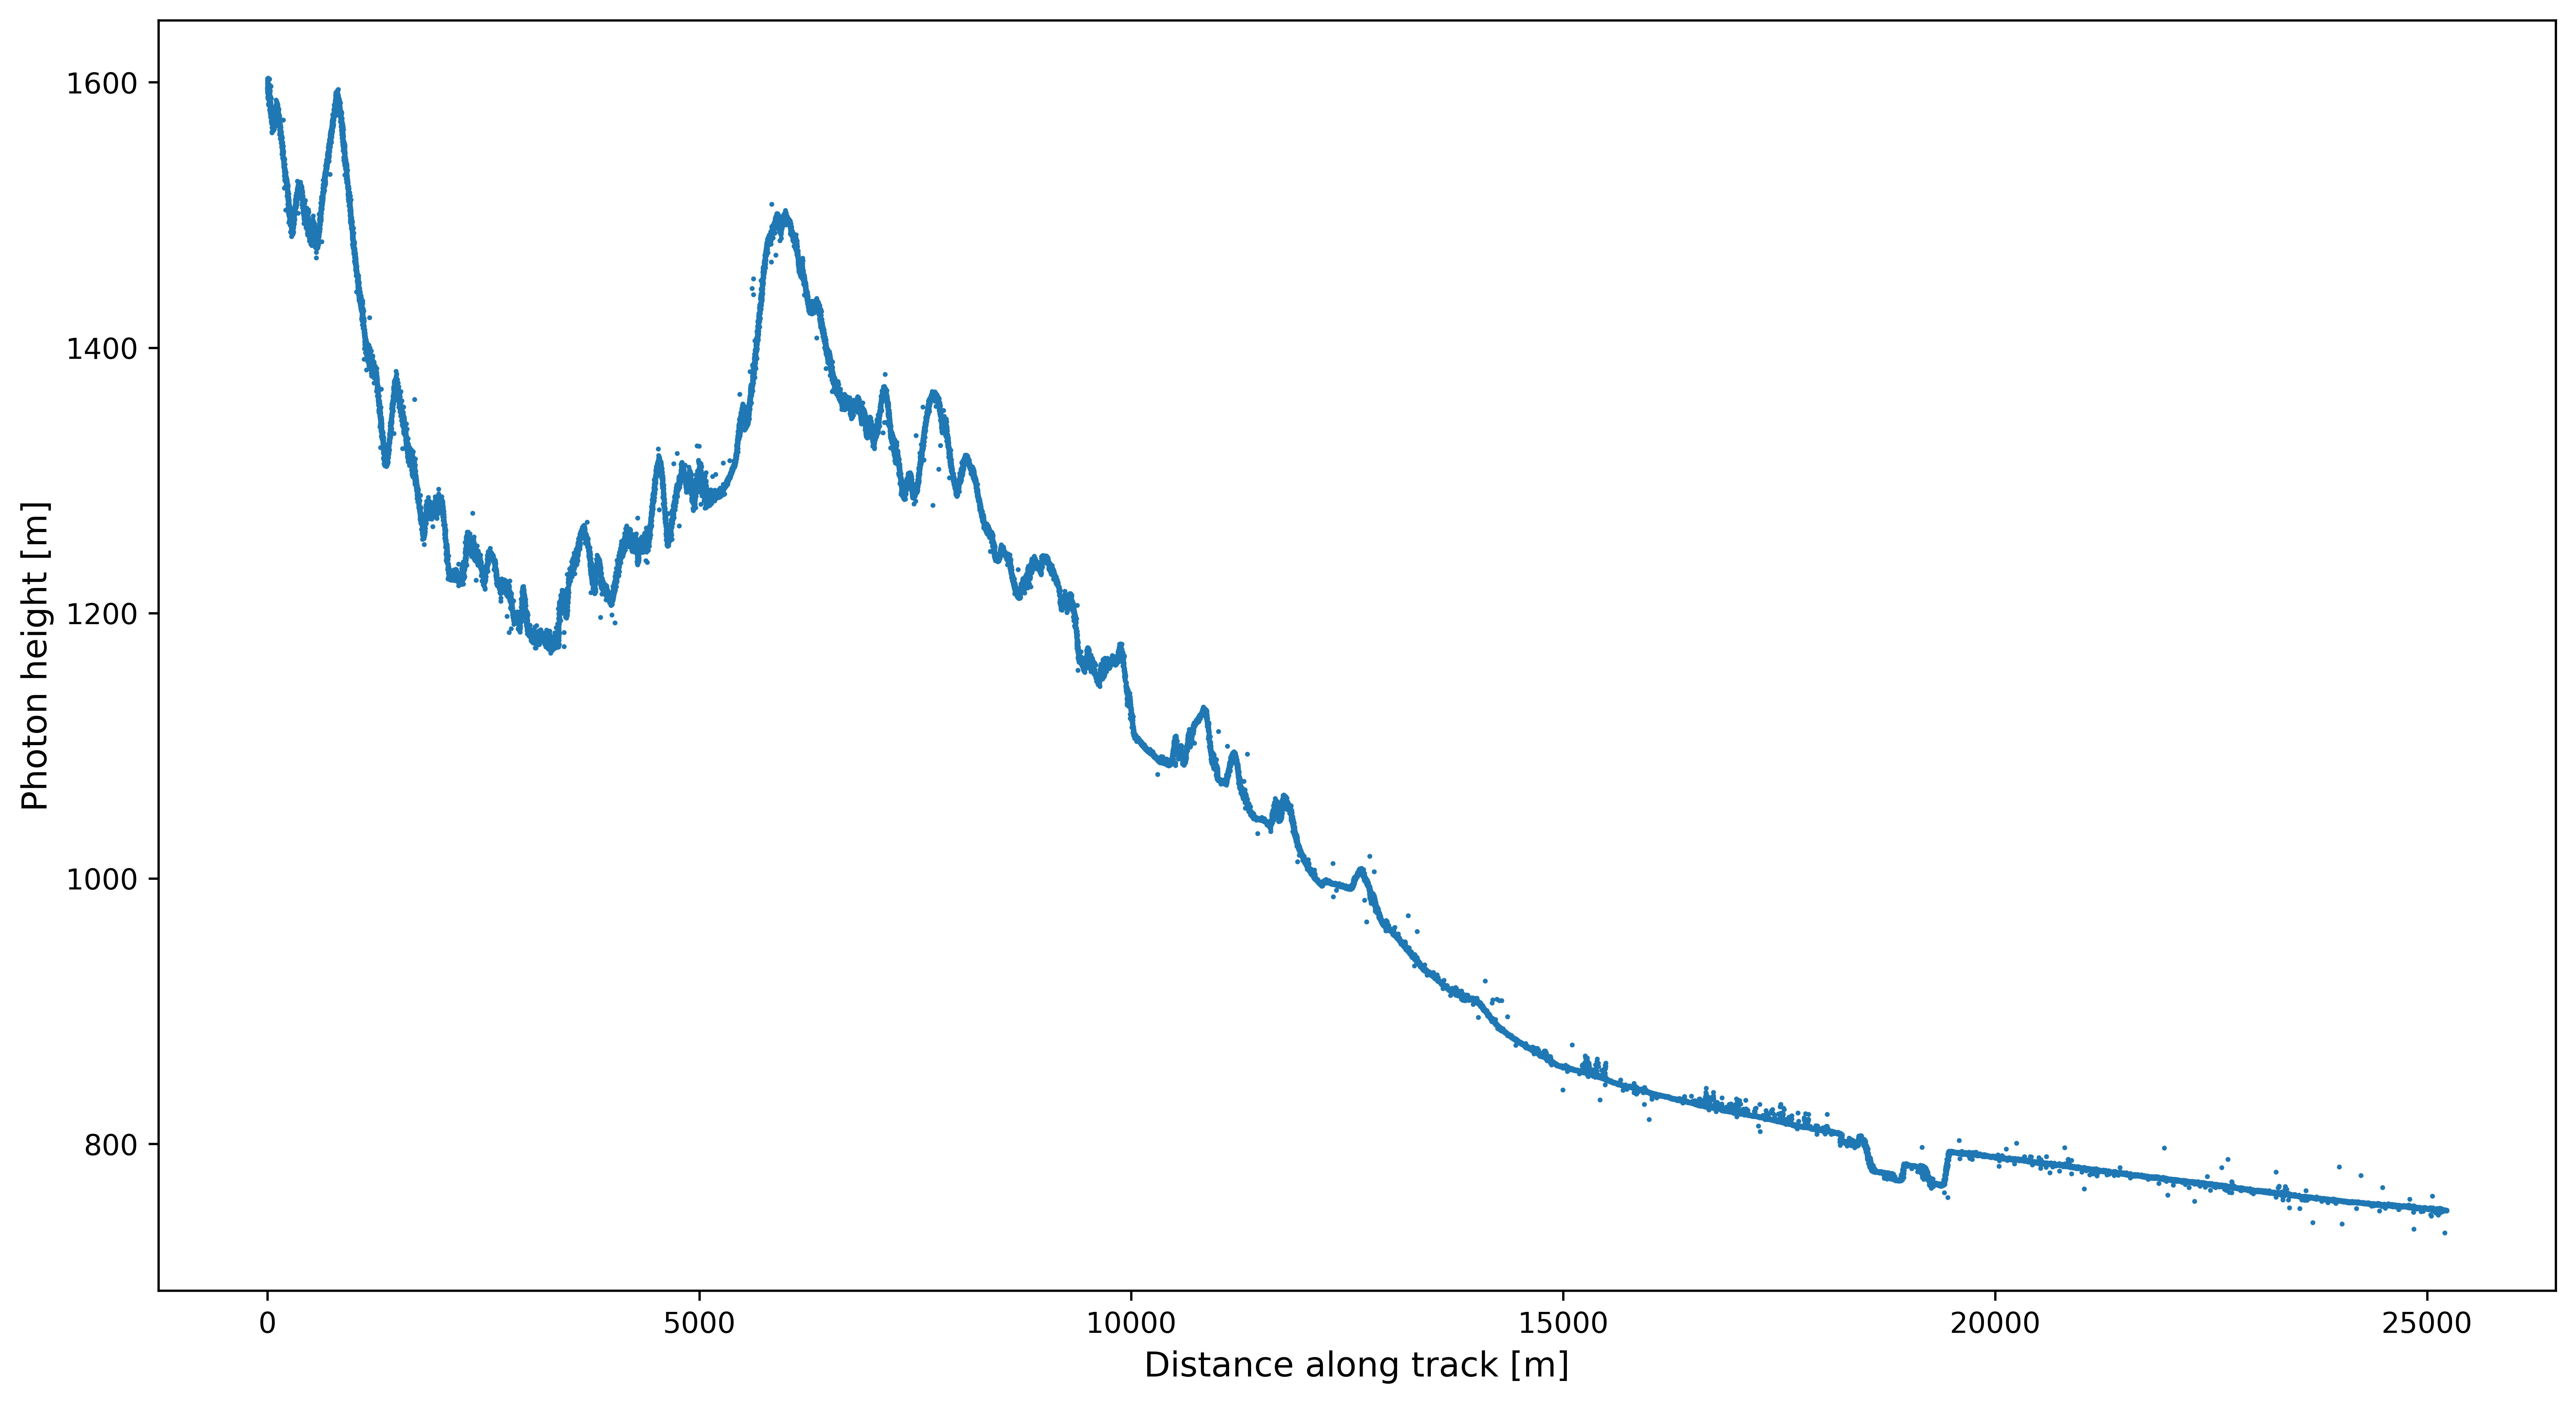

In [9]:
# show the new subset
fig, ax = plt.subplots(1,1, figsize=(15,8))
fig.set_dpi(600)
ax.scatter(gdf_short.alongtrack_new,  gdf_short.Photon_Height, s=0.5);
ax.set_ylabel('Photon height [m]', fontsize=12)
ax.set_xlabel('Distance along track [m]', fontsize=12);

In [9]:
# for the conversion, the clipped gdf is thinned out to improve computation time
gdf2 = gdf_short.iloc[::20]
print(len(gdf2))

3738


## conversion of geodetic reference frame (WGS84 ITRF2014 --> NAD83 (2011) --> NAVD88)

Photons are in geographic CS WGS84, WGS84 ellipsoid, EPSG 4326; vertical is in ITRF2014 (EPSG 7912)

DEM is in NAVD88 (NAD83 - geoid)

| EPSG | meaning| units |
|:----:|:-------:|:-------:|
| 6319 | NAD83(2011) - Ellipsoidal 3D| latlon+h |
| 7912 | ITRF2014 - Ellipsoidal 3D | latlon+h |



In [13]:
for index, row in gdf2.iterrows():
       os.system("echo " + str(row['Latitude']) + " " + str(row['Longitude']) + " " + str(row['Photon_Height']) + " | cs2cs -d 3  EPSG:7912 EPSG:6319 >> ../data/transformed_to_NAD83.txt")

In [10]:
# import the NAD83 height values
newval = np.loadtxt('../data/transformed_to_NAD83.txt')
gdf2['PhH_nad83'] = newval[:,2].tolist()

# derive the conversion value (WGS84 ITRF2014 --> NAD83 (2011))
gdf2['corr_value'] = (gdf2.Photon_Height-gdf2.PhH_nad83).tolist()

In [11]:
# conversion was done on the shortened dataframe --> interpolation back to full length
corr_interp = np.interp(x = gdf_short.index, xp = gdf2.index, fp = gdf2.corr_value)
gdf_short['corr_value'] = corr_interp.tolist()

# apply conversion to DEM on the long gdf
gdf_short['PhH_nad83'] = (gdf_short.Photon_Height-gdf_short.corr_value).tolist()

In [12]:
# ellipsoidal (NAD83) to orthometric: orthometric = ellipsoidal - geoid height
gdf_short['PhH_navd88'] = (gdf_short.PhH_nad83-gdf_short.geoid_float).tolist()

## DEM interpolation

In [13]:
# load the DEM as array for the interpolation
array = src_1m.read()
array[array == -9999] = np.nan
array = np.squeeze(array, axis=0)

# make grid for latitude/longitude values
x,y = np.meshgrid(np.linspace(src_1m.bounds[0],src_1m.bounds[2],array.shape[1]), np.linspace(src_1m.bounds[3],src_1m.bounds[1],array.shape[0]))

# convert to (n,3) array
xyz_als = np.c_[x.flatten(), y.flatten(), array.flatten()]

# remove invalid points
xyz_als = xyz_als[~np.isnan(xyz_als[:,2])][::-1]
xyz_als = xyz_als[xyz_als[:,2] > 700]

In [15]:
# get NAVD88 elevation of first photon to adjust the DEM extent
gdf_short.dem_1m_navd88.iloc[0]

1627.451904296875

In [14]:
# edge effects have to be removed manually 
xyz_als = xyz_als[19:]
xyz_als

array([[-117.96550102,   34.38263107, 1637.30688477],
       [-117.96551092,   34.38263107, 1635.93310547],
       [-117.96552081,   34.38263107, 1634.69702148],
       ...,
       [-117.99180032,   34.609128  ,  782.87542725],
       [-117.99181022,   34.609128  ,  782.86724854],
       [-117.99182011,   34.609128  ,  782.85626221]])

In [15]:
# make ICESat (n,3) array
xyz_icesat = np.c_[gdf_short.Longitude, gdf_short.Latitude, gdf_short.dem_1m_navd88]
xyz_icesat

array([[-117.96561637,   34.38264401, 1627.4519043 ],
       [-117.96561627,   34.38264405, 1627.4519043 ],
       [-117.9656162 ,   34.38264407, 1627.4519043 ],
       ...,
       [-117.99183432,   34.60910389,  782.86975098],
       [-117.99183432,   34.60910389,  782.86975098],
       [-117.99183431,   34.6091039 ,  782.86975098]])

In [16]:
# create interpolation plane
interp = LinearNDInterpolator(list(zip(xyz_als[:,0], xyz_als[:,1])), xyz_als[:,2])
# interpolate elevation at icesat location
icesat_interpolated = interp(xyz_icesat[:,0], xyz_icesat[:,1])

Average difference: 0.10 m


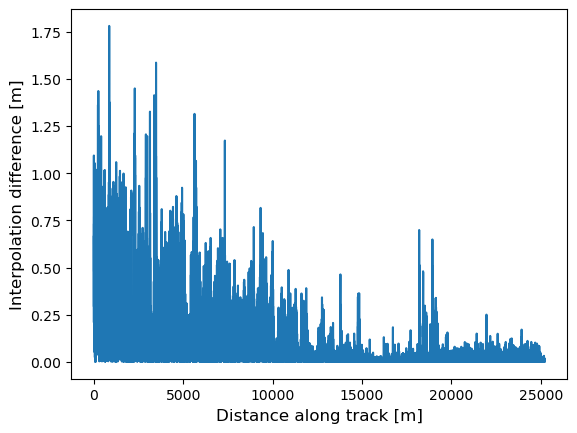

In [40]:
# difference between interpolated DEM and DEM cell values
diff = np.abs(icesat_interpolated - xyz_icesat[:,2])
print(f'Average difference: {np.mean(diff):.2f} m')
fig, ax = plt.subplots()
ax.plot(gdf_short.alongtrack_new, diff);
ax.set_ylabel('Interpolation difference [m]', fontsize=12)
ax.set_xlabel('Distance along track [m]', fontsize=12);
plt.savefig('../writing/img/DEM_interpolation_diff.png', dpi=300, transparent=True, bbox_inches='tight');

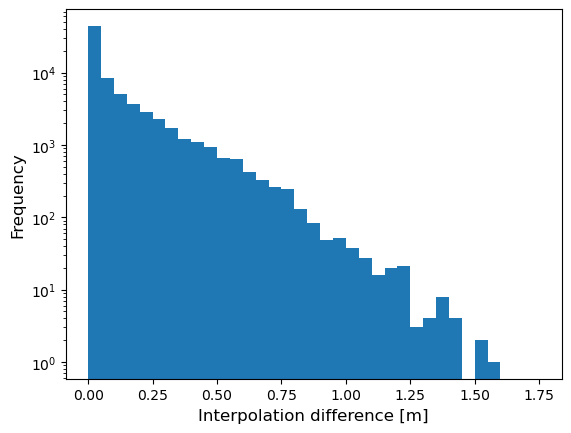

In [33]:
# difference as histogram
fig, ax = plt.subplots()
ax.hist(diff, bins=np.arange(0,diff.max(), 0.05),log=True, density=False);
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Interpolation difference [m]', fontsize=12);
plt.savefig('../writing/img/DEM_interpolation_diff_hist.png', dpi=300, transparent=True, bbox_inches='tight')

In [18]:
diff.max()

1.780392586407288

In [19]:
diff.min()

1.7268644114665221e-07

In [20]:
# show DEM NADV88 values side by side (cell value vs interpolated)
np.c_[xyz_icesat, icesat_interpolated]

array([[-117.96561637,   34.38264401, 1627.4519043 , 1626.78879571],
       [-117.96561627,   34.38264405, 1627.4519043 , 1626.79501993],
       [-117.9656162 ,   34.38264407, 1627.4519043 , 1626.79928729],
       ...,
       [-117.99183432,   34.60910389,  782.86975098,  782.88323025],
       [-117.99183432,   34.60910389,  782.86975098,  782.88323272],
       [-117.99183431,   34.6091039 ,  782.86975098,  782.88324083]])

In [21]:
gdf_short['dem_1m_navd88_intp'] = icesat_interpolated.tolist()

In [22]:
gdf_short

,level_0,index,Latitude,Longitude,Photon_Height,alongtrack_base,geometry,geoid_float,dem_1m_navd88,dem_1m_slp_float,alongtrack_new,corr_value,PhH_nad83,PhH_navd88,dem_1m_navd88_intp
0,65189,1465798,34.382644,-117.965616,1593.746338,22027.387204,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913,0.000000,-0.701662,1594.448000,1625.904400,1626.788796
1,65190,1465797,34.382644,-117.965616,1595.324829,22027.390305,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913,0.003101,-0.701659,1596.026488,1627.482888,1626.795020
2,65191,1465799,34.382644,-117.965616,1596.407104,22027.392431,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913,0.005226,-0.701655,1597.108760,1628.565159,1626.799287
3,65192,1465795,34.382644,-117.965616,1602.720825,22027.404605,POINT (-117.96562 34.38264),-31.456400,1627.451904,44.144913,0.017400,-0.701652,1603.422477,1634.878877,1626.824254
4,65193,1465800,34.382650,-117.965617,1595.209717,22028.102334,POINT (-117.96562 34.38265),-31.456400,1627.451904,42.367153,0.715130,-0.701648,1595.911365,1627.367765,1626.555063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74744,144066,1544671,34.609097,-117.991834,749.839539,47252.538308,POINT (-117.99183 34.60910),-32.193001,782.882568,0.782531,25225.151103,-0.696683,750.536222,782.729222,782.888446
74745,144067,1544675,34.609104,-117.991834,749.403809,47253.254661,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551,25225.867456,-0.696683,750.100492,782.293492,782.883212
74746,144068,1544676,34.609104,-117.991834,749.800659,47253.255437,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551,25225.868233,-0.696683,750.497342,782.690343,782.883230
74747,144069,1544674,34.609104,-117.991834,749.871033,47253.255575,POINT (-117.99183 34.60910),-32.193001,782.869751,0.849551,25225.868371,-0.696683,750.567716,782.760717,782.883233


In [23]:
# drop DEM height in NAD83
gdf_short = gdf_short.drop(['alongtrack_base', 'dem_1m_navd88', 'PhH_nad83'], axis=1)

In [36]:
xz = gdf_short[['alongtrack_new', 'PhH_navd88']].to_numpy()
xz

array([[0.00000000e+00, 1.62590440e+03],
       [3.10060580e-03, 1.62748289e+03],
       [5.22640161e-03, 1.62856516e+03],
       ...,
       [2.52258682e+04, 7.82690343e+02],
       [2.52258684e+04, 7.82760717e+02],
       [2.52258688e+04, 7.82991368e+02]])

In [33]:
dem = gdf_short[['alongtrack_new', 'dem_1m_navd88_intp']].to_numpy()
dem

array([[0.00000000e+00, 1.62678880e+03],
       [3.10060580e-03, 1.62679502e+03],
       [5.22640161e-03, 1.62679929e+03],
       ...,
       [2.52258682e+04, 7.82883230e+02],
       [2.52258684e+04, 7.82883233e+02],
       [2.52258688e+04, 7.82883241e+02]])

In [34]:
np.save('../data/export/xz.npy', xz)
np.save('../data/export/dem.npy', dem)

In [37]:
# save as shapefile
with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=UserWarning)
        gdf_short.to_file(f'../data/beams/SGM/SAF_20220901_DEMs_GT3R_intp.shp')